# The Validation partition of the dataset

This notebook presents some of the common practices in training a classification model, namely:

- use of a validation set
- early stopping
- learning rate scheduler

# Auxiliary Function

In [78]:
import torch
import torchvision
import torchvision.transforms as transforms

import torchinfo

import matplotlib.pyplot as plt
import numpy as np
import time

import sys
sys.path.insert(1, './util')
import vcpi_util

In [79]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
print(device)

BATCH_SIZE = 32
EPOCHS = 20

cuda:0


In [80]:
PATH_TRAINING_SET = "./gtsrb_datasets/train"
PATH_TEST_SET = "./gtsrb_datasets/test"

In [81]:
trasnform = transforms.Compose([transforms.Resize((32,32)), transforms.ToTensor()])

In [82]:
def evaluate(model, data_loader):

    # sets the model in evaluation mode.
    # although our model does not have layers which behave differently during training and evaluation
    # this is a good practice as the models architecture may change in the future
    model.eval()

    correct = 0
    
    for i, (images, targets) in enumerate(data_loader):
         
        # forward pass, compute the output of the model for the current batch
        outputs = model(images.to(device))

        # "max" returns a namedtuple (values, indices) where values is the maximum 
        # value of each row of the input tensor in the given dimension dim; 
        # indices is the index location of each maximum value found (argmax).
        # the argmax effectively provides the predicted class number        
        _, preds = torch.max(outputs, dim=1)

        correct += (preds.cpu() == targets).sum()

    return (correct / len(data_loader.dataset)).item()


In [83]:
import torch.utils


train_set = torchvision.datasets.ImageFolder(root=PATH_TRAINING_SET, transform=trasnform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

test_set = torchvision.datasets.ImageFolder(root=PATH_TEST_SET, transform=trasnform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)


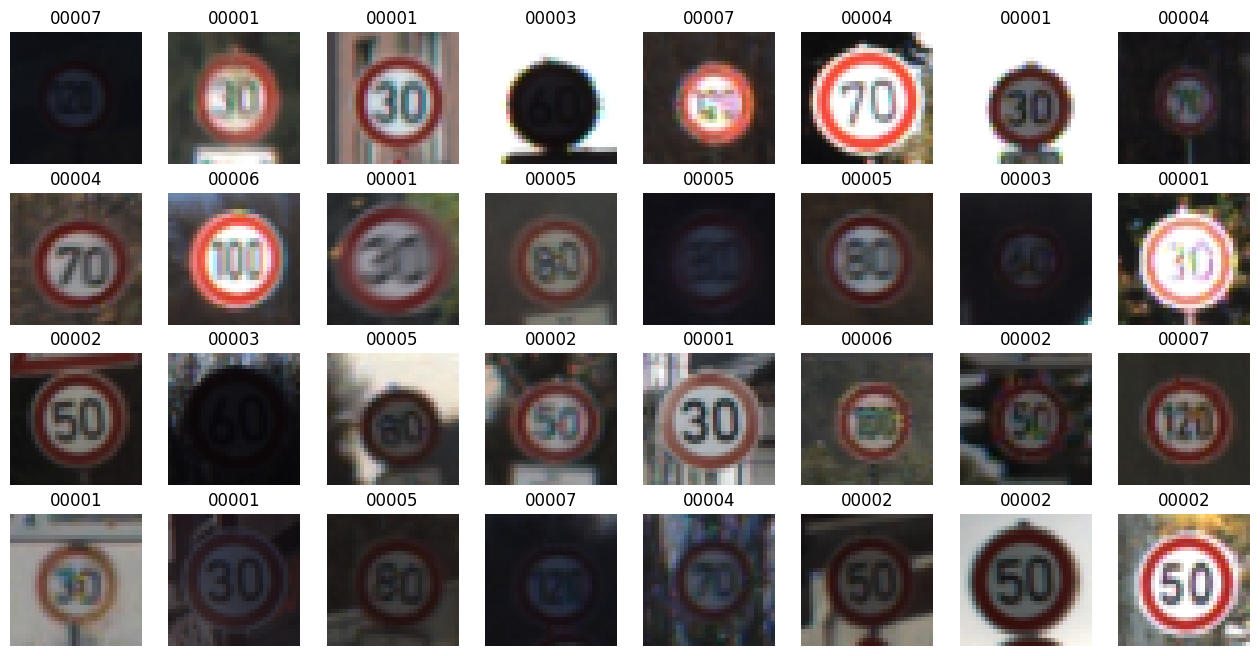

<Figure size 640x480 with 0 Axes>

In [84]:
images, targets = next(iter(train_loader))
vcpi_util.show_images(4, 8, images, targets,train_set.classes)

In [85]:
class Conv_II(torch.nn.Module):
    def __init__(self, num_classes):

        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, 3)
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.relu1 = torch.nn.ReLU()

        self.conv2 = torch.nn.Conv2d(16, 32, 3)
        self.bn2 = torch.nn.BatchNorm2d(32)
        self.relu2 = torch.nn.ReLU()

        self.maxpool1 = torch.nn.MaxPool2d(2) 
        
        self.conv3 = torch.nn.Conv2d(32, 48, 3)
        self.bn3 = torch.nn.BatchNorm2d(48)
        self.relu3 = torch.nn.ReLU()
        
        self.conv4 = torch.nn.Conv2d(48, 48, 3)
        self.bn4 = torch.nn.BatchNorm2d(48)
        self.relu4 = torch.nn.ReLU()
        
        self.maxpool2 = torch.nn.MaxPool2d(2)


        self.fc1 = torch.nn.Linear(1200, num_classes)

    def forward(self,x):
        # input = (bs, 1, 32, 32)

        x = self.conv1(x) # -> (bs, 16, 30, 30)
        x = self.bn1(x)
        x = self.relu1(x)
        
        x = self.conv2(x) # -> (bs, 32, 28, 28)
        x = self.bn2(x)
        x = self.relu2(x)
        
        x = self.maxpool1(x) # -> bs(32 canais, 14 x 14)

        x = self.conv3(x) # -> (bs, 48, 12, 12)
        x = self.bn3(x)
        x = self.relu3(x)
        
        x = self.conv4(x) # -> (bs, 48, 10, 10)
        x = self.bn4(x)
        x = self.relu4(x)

        x = self.maxpool2(x) # -> bs(32 canais, 5 x 5)
        
        x = torch.flatten(x, 1) # Gera um array bs 48 * 4 * 4
        x = self.fc1(x) # -> bs, 768 para bs, 10


        return (x)
    
model_conv_II = Conv_II(len(train_set.classes))
model_conv_II.to(device)
print(model_conv_II)

torchinfo.summary(model_conv_II,input_size = (BATCH_SIZE, 3, 32, 32))

Conv_II(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (conv4): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1200, out_features=8, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
Conv_II                                  [32, 8]                   --
├─Conv2d: 1-1                            [32, 16, 30, 30]          448
├─BatchNorm2d: 1-2                       [32, 16, 30, 30]          32
├─ReLU: 1-3                              [32, 16, 30, 30]          --
├─Conv2d: 1-4                            [32, 32, 28, 28]          4,640
├─BatchNorm2d: 1-5                       [32, 32, 28, 28]          64
├─ReLU: 1-6                              [32, 32, 28, 28]          --
├─MaxPool2d: 1-7                         [32, 32, 14, 14]          --
├─Conv2d: 1-8                            [32, 48, 12, 12]          13,872
├─BatchNorm2d: 1-9                       [32, 48, 12, 12]          96
├─ReLU: 1-10                             [32, 48, 12, 12]          --
├─Conv2d: 1-11                           [32, 48, 10, 10]          20,784
├─BatchNorm2d: 1-12                      [32, 48, 10, 10]          96
├─R

In [86]:
def train(model, data_loader, epochs, loss_fn, optimizer):
    
    model.train()

    history = {}
    history["accuracy"] = []
    history["loss"] = []

    for epoch in range(epochs):
        start_time = time.time()
        correct = 0
        running_loss = 0

        for i, (inputs, targets) in enumerate(data_loader, 0):
            
            # PASSA PARA GPU
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            loss = loss_fn(outputs, targets)
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
            
            # ESTATISTICAS
            _,pred = torch.max(outputs, 1)
            correct += (pred == targets).sum()

            running_loss += loss


        t_correct = 0
        for i,t in test_loader:
            i = i.to(device)
            t = t.to(device)
            o = model(i)

            _, p = torch.max(o, 1)
            t_correct += (t == p).sum()




        accuracy = 100 * correct/len(train_set)
        stop_time = time.time()

        print(f'Epoch: {epoch:03d}; Acc = {accuracy:0.4f}; ACC_T = {100*t_correct/len(test_set)}; Time = {(stop_time - start_time):0.4f}')
        history['accuracy'].append(accuracy.cpu().numpy())
        history["loss"].append(running_loss.cpu().detach().numpy())
    return history

In [87]:
optimizer_I = torch.optim.Adam(model_conv_II.parameters())
loss_fn = torch.nn.CrossEntropyLoss()

history_I = train(model_conv_II, train_loader, EPOCHS, loss_fn, optimizer_I)

Epoch: 000; Acc = 87.1274; ACC_T = 91.58273315429688; Time = 28.2144
Epoch: 001; Acc = 99.3824; ACC_T = 93.98081970214844; Time = 8.6853
Epoch: 002; Acc = 99.8922; ACC_T = 95.87529754638672; Time = 8.6667
Epoch: 003; Acc = 99.9804; ACC_T = 96.35491943359375; Time = 8.8542
Epoch: 004; Acc = 99.9804; ACC_T = 96.85851287841797; Time = 8.6042
Epoch: 005; Acc = 100.0000; ACC_T = 96.23501586914062; Time = 8.6322
Epoch: 006; Acc = 98.8529; ACC_T = 96.40287780761719; Time = 8.6171
Epoch: 007; Acc = 99.6176; ACC_T = 93.98081970214844; Time = 8.5696
Epoch: 008; Acc = 99.9412; ACC_T = 97.02638244628906; Time = 8.5952
Epoch: 009; Acc = 100.0000; ACC_T = 97.57794189453125; Time = 8.5996
Epoch: 010; Acc = 100.0000; ACC_T = 97.67385864257812; Time = 8.7425
Epoch: 011; Acc = 100.0000; ACC_T = 97.67385864257812; Time = 8.7783
Epoch: 012; Acc = 100.0000; ACC_T = 97.6498794555664; Time = 8.6246
Epoch: 013; Acc = 100.0000; ACC_T = 97.67385864257812; Time = 8.6605
Epoch: 014; Acc = 100.0000; ACC_T = 97.553

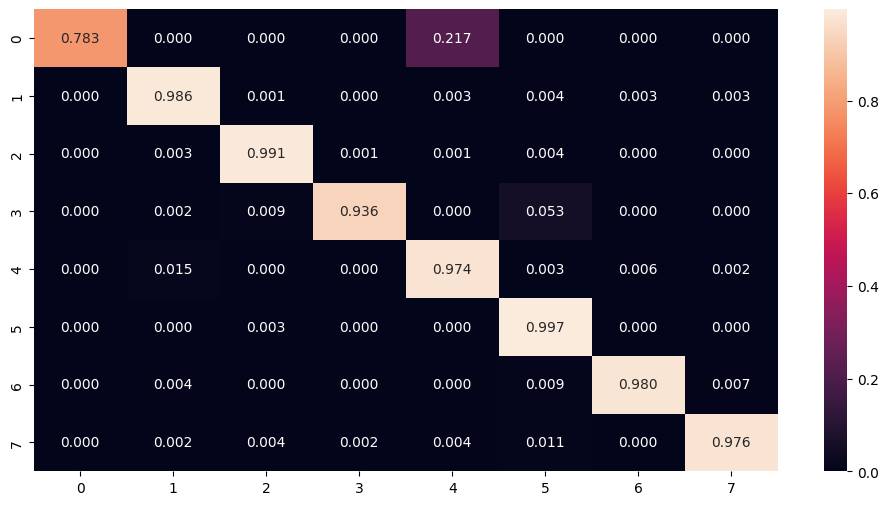

In [88]:
preds = []
ground_truth = []

for images, targets in test_loader:

    logits = model_conv_II(images.to(device))
    preds_aux = [np.argmax(x) for x in logits.cpu().detach().numpy()]
    preds.extend(preds_aux)
    ground_truth.extend(targets.numpy())

vcpi_util.show_confusion_matrix(ground_truth, preds, 8)

Counter({2: 1770, 1: 1740, 4: 1590, 5: 1500, 6: 1170, 3: 1140, 7: 1110, 0: 180})


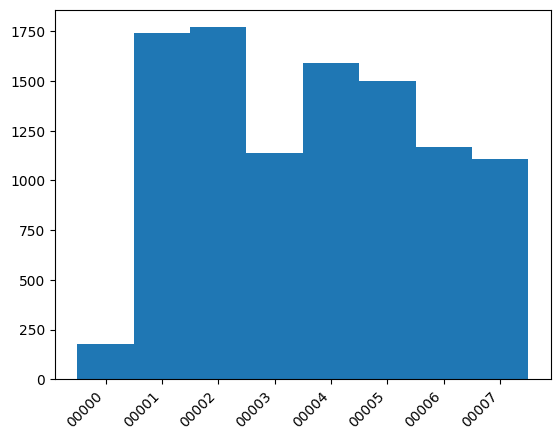

In [89]:
target_list = []

for images, targets in train_loader:
    target_list.extend(targets)
vcpi_util.show_histogram(target_list,train_set.classes)